<a href="https://colab.research.google.com/github/adedert/IANNWTF_FinalProject/blob/main/Lunar_Lander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install swig
!pip install gymnasium[box2d]

In [ ]:
#import gymnasium as gym
import numpy as np
from collections import namedtuple, deque
import random
import pickle
import matplotlib.pyplot as plt
#from google.colab import drive
#drive.mount('/content/drive')

import tensorflow as tf
from model import DQN
from agent import dqn_agent

In [ ]:
#DQN Training
agent = dqn_agent(env_name="LunarLander-v2", erp_size=100000, tau=0.999, gamma=0.99, learning_rate=0.001, double_q=False, eps_min=0.01, eps_decay=0.99)
agent.train()

Episode 100 | Total point average of the last 100 episodes: -160.14
Episode 200 | Total point average of the last 100 episodes: -117.89
Episode 300 | Total point average of the last 100 episodes: -44.55
Episode 400 | Total point average of the last 100 episodes: -10.47
Episode 500 | Total point average of the last 100 episodes: 59.56
Episode 600 | Total point average of the last 100 episodes: 150.83
Episode 700 | Total point average of the last 100 episodes: 3.57
Episode 800 | Total point average of the last 100 episodes: 97.11
Episode 864 | Total point average of the last 100 episodes: 202.66Environment solved in 864 episodes!
Episode 900 | Total point average of the last 100 episodes: 226.77
Episode 1000 | Total point average of the last 100 episodes: 243.79
Episode 1047 | Total point average of the last 100 episodes: 252.81

In [5]:
#Double DQN Training
agent = dqn_agent(env_name="LunarLander-v2", erp_size=100000, tau=0.999, gamma=0.99, learning_rate=0.001, double_q=True, eps_min=0.01, eps_decay=0.99)
agent.train()

Episode 100 | Total point average of the last 100 episodes: -145.68
Episode 200 | Total point average of the last 100 episodes: -99.65
Episode 300 | Total point average of the last 100 episodes: -46.28
Episode 400 | Total point average of the last 100 episodes: 73.32
Episode 500 | Total point average of the last 100 episodes: 186.15
Episode 541 | Total point average of the last 100 episodes: 200.26Environment solved in 541 episodes!
Episode 600 | Total point average of the last 100 episodes: 217.17
Episode 674 | Total point average of the last 100 episodes: 250.19

# Visualization

In [2]:
PATH = 'rewards/'
with open(PATH + 'dqn_rewards.pkl', 'rb') as f:
  dqn_rewards = pickle.load(f)
with open(PATH + 'double_dqn_rewards.pkl', 'rb') as f:
  double_dqn_rewards = pickle.load(f)
with open(PATH + 'solo_dqn_rewards.pkl', 'rb') as f:
  solo_dqn_rewards = pickle.load(f)
with open(PATH + 'avg_rwd_dqn.pkl', 'rb') as f:
  avg_rwd_dqn = pickle.load(f)
with open(PATH + 'avg_rwd_double_dqn.pkl', 'rb') as f:
  avg_rwd_double_dqn = pickle.load(f)
with open(PATH + 'avg_rwd_solo_dqn.pkl', 'rb') as f:
  avg_rwd_solo_dqn = pickle.load(f)

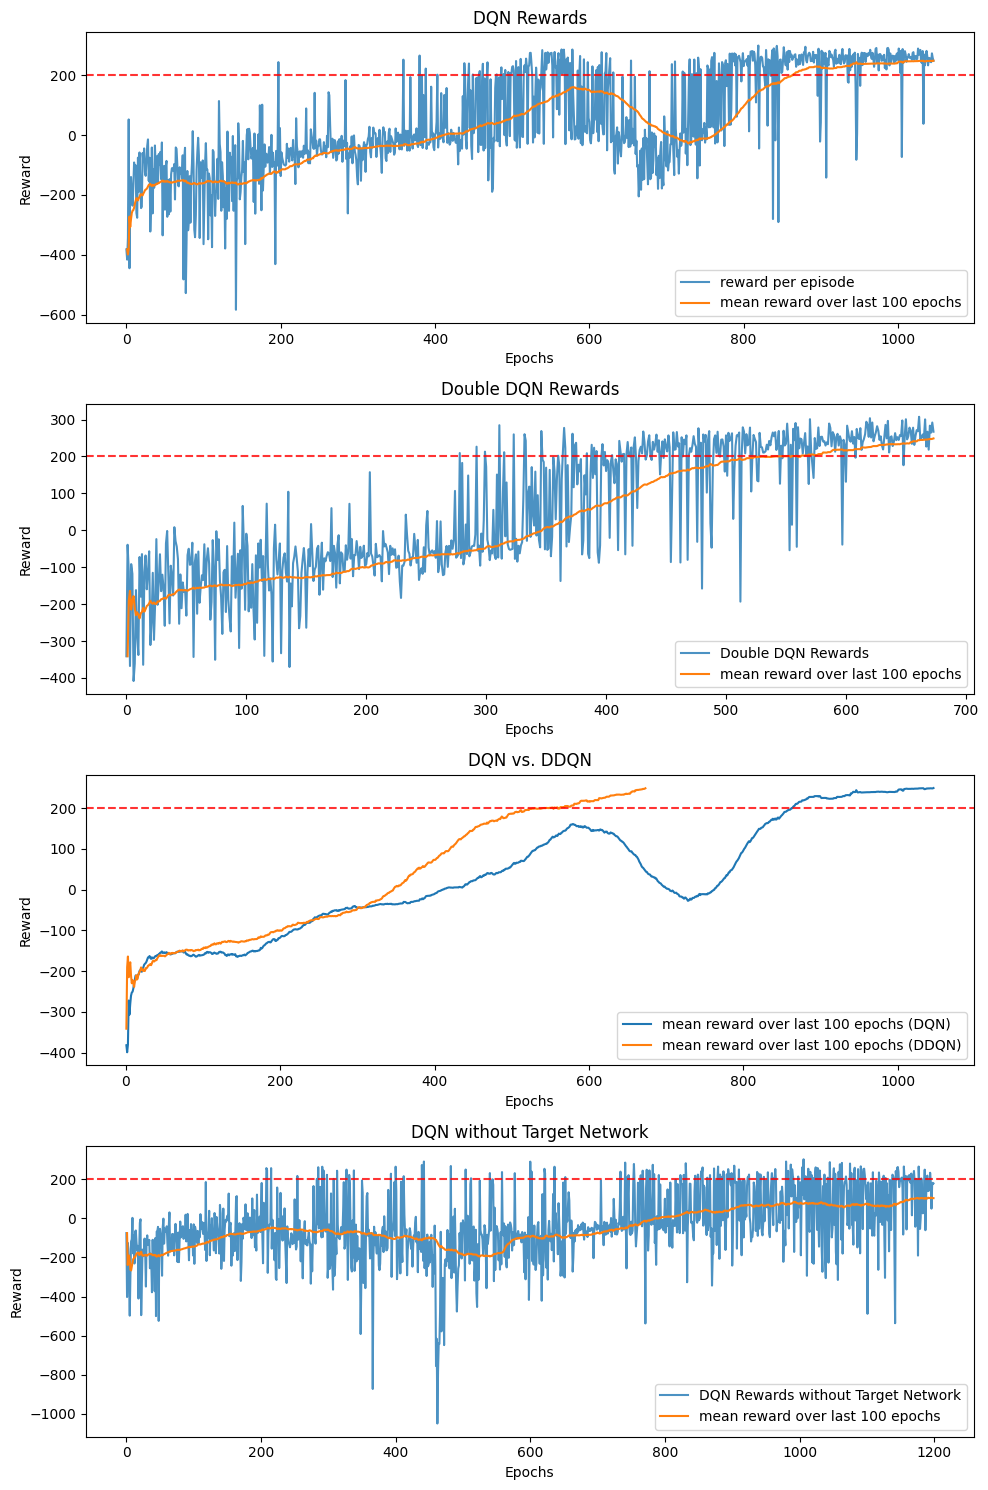

In [8]:
#
fig, axs = plt.subplots(4, 1, figsize=(10, 15))

# First subplot
axs[0].plot(dqn_rewards, label='reward per episode', alpha=0.8)
axs[0].plot(avg_rwd_dqn, label='mean reward over last 100 epochs')
axs[0].axhline(y=200, color='red', linestyle='--', alpha=0.8)
axs[0].set_title('DQN Rewards')
axs[0].legend(loc='lower right')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Reward')

# Second subplot
axs[1].plot(double_dqn_rewards, label='Double DQN Rewards', alpha=0.8)
axs[1].plot(avg_rwd_double_dqn, label='mean reward over last 100 epochs')
axs[1].axhline(y=200, color='red', linestyle='--', alpha=0.8)
axs[1].set_title('Double DQN Rewards')
axs[1].legend(loc='lower right')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Reward')

# Third subplot
axs[2].plot(avg_rwd_dqn, label='mean reward over last 100 epochs (DQN)')
axs[2].plot(avg_rwd_double_dqn, label='mean reward over last 100 epochs (DDQN)')
axs[2].axhline(y=200, color='red', linestyle='--', alpha=0.8)
axs[2].set_title('DQN vs. DDQN')
axs[2].legend(loc='lower right')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Reward')

# Third subplot
axs[3].plot(solo_dqn_rewards, label='DQN Rewards without Target Network', alpha=0.8)
axs[3].plot(avg_rwd_solo_dqn, label='mean reward over last 100 epochs')
axs[3].axhline(y=200, color='red', linestyle='--', alpha=0.8)
axs[3].set_title('DQN without Target Network')
axs[3].legend(loc='lower right')
axs[3].set_xlabel('Epochs')
axs[3].set_ylabel('Reward')

plt.tight_layout()
plt.show()
